In [1]:
:set -XFlexibleContexts -XMonadComprehensions -XNoImplicitPrelude -XRebindableSyntax
import Language.Stochaskell
stochaskell

Stochaskell, version 0.1.0
Copyright (C) 2015-2019 David A Roberts
This program comes with ABSOLUTELY NO WARRANTY.
This is free software, and you are welcome to redistribute it
under certain conditions; see the LICENSE for details.

Using installation directory at 
  /home/jovyan/stochaskell

In [2]:
:opt svg
import Language.Stochaskell.Plot

In [3]:
poissonProc :: R -> P R -> P RVec
poissonProc m f = do
  n <- poisson m
  xs <- orderedSample n f
  return xs

In [4]:
poissonProcHomo :: R -> R -> P RVec
poissonProcHomo rate t = do
  poissonProc (rate * t) (uniform 0 t)

In [5]:
simulate (poissonProcHomo 1 5)

[1.1982491202898187,2.378494410423593,2.8492806571801483,2.9917650457291405,3.2513777986482917,3.7365629817526544]

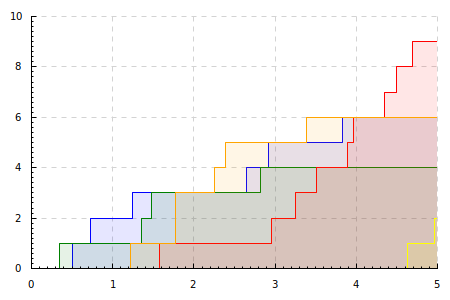

In [6]:
samples <- sequence [simulate (poissonProcHomo 1 5) | i <- [1..5]]
toRenderable $ sequence $ plotStep "" (0,5) . list <$> samples

In [7]:
gp :: (R -> R -> R) -> Z -> RVec -> P RVec
gp kernel n x = do
  let mu = vector [ 0 | i <- 1...n ]
      cov = matrix [ kernel (x!i) (x!j) | i <- 1...n, j <- 1...n ]
  g <- normal mu cov
  return g

In [8]:
kernelSE1 = kernelSE (log 1) (log 1)

kernelSE lsv lls2 a b =
  exp (lsv - (a - b)^2 / (2 * exp lls2))
  + if a == b then 1e-6 else 0

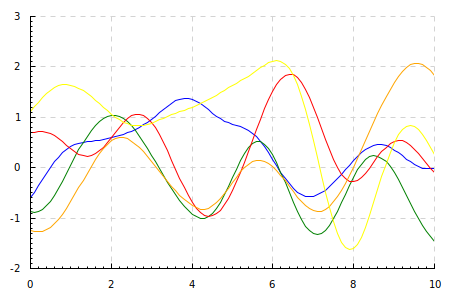

In [9]:
let test = list [i/10 | i <- [0..100]]
samples <- sequence [simulate (gp kernelSE1 101 test) | i <- [1..5]]
toRenderable $ sequence [plot $ line "" [test `zip` list ys] | ys <- samples]

In [10]:
normalChol :: Z -> RVec -> RMat -> P RVec
normalChol n mu cov = do
  w <- joint vector [ normal 0 1 | i <- 1...n ]
  return (mu + chol cov #> w)

In [11]:
gpChol :: (R -> R) -> (R -> R -> R) -> Z -> RVec -> P RVec
gpChol expect kernel n x = do
  let mu  = vector [ expect (x!i) | i <- 1...n ]
      cov = matrix [ kernel (x!i) (x!j) | i <- 1...n, j <- 1...n ]
  g <- normalChol n mu cov
  return g

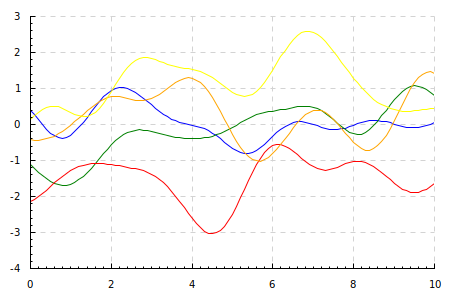

In [12]:
samples <- sequence [simulate (gpChol (const 0) kernelSE1 101 test) | i <- [1..5]]
toRenderable $ sequence [plot $ line "" [test `zip` list ys] | ys <- samples]

In [13]:
gpClassifier :: (R -> R -> R) -> Z -> RVec -> P (RVec,BVec)
gpClassifier kernel n x = do
  g <- gpChol (const 0) kernel n x
  phi <- joint vector [ bernoulliLogit (g!i) | i <- 1...n ]
  return (g,phi)

In [14]:
model :: R -> P (Z,RVec,RVec,BVec)
model rate = do
  x <- poissonProcHomo rate 10
  let n = vectorSize x
  (y,z) <- gpClassifier kernelSE1 n x
  return (n,x,y,z)

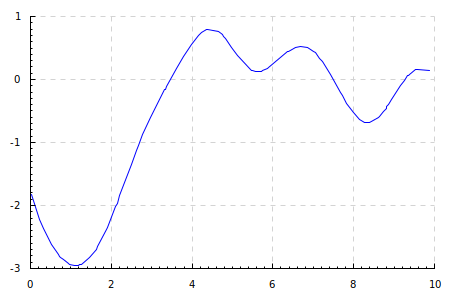

In [15]:
(n,x,y,z) <- simulate (model 10)
toRenderable . plot $ line "" [list x `zip` list y]

In [16]:
samples <- hmcStan 1000 [y' | (n',x',y',z') <- model 5, n' == n, x' == x, z' == z]

--- Generating Stan code ---
functions {
  // https://github.com/stan-dev/stan/issues/452
  real to_real(real x) { return x; }
}
data {
  int x_stan_0_0;
  vector[x_stan_0_0] x_stan_0_1;
  
  int<lower=0,upper=1> x_stan_0_3[x_stan_0_0];
}
parameters {
  
  
  vector[x_stan_0_0] x_stan_0_2;
  
}
model {
  
  vector[x_stan_0_0] v_0_1;
  
  matrix[x_stan_0_0,x_stan_0_0] v_0_3;
  matrix[x_stan_0_0,x_stan_0_0] v_0_4;
  
  vector[x_stan_0_0] v_0_6;
  vector[x_stan_0_0] v_0_7;
  
  for (i_1_1 in 1:x_stan_0_0) {
  
    v_0_1[i_1_1] = 0;
  }
  
  for (i_1_1 in 1:x_stan_0_0) for (i_1_2 in 1:x_stan_0_0) {
    real v_1_0;
    real v_1_1;
    real v_1_2;
    real v_1_3;
    real v_1_4;
    int v_1_5;
    real v_1_6;
    real v_1_7;
    v_1_0 = x_stan_0_1[i_1_1] - x_stan_0_1[i_1_2];
    v_1_1 = v_1_0 .* v_1_0;
    v_1_2 = to_real(v_1_1) ./ to_real(2);
    v_1_3 = -(v_1_2);
    v_1_4 = exp(v_1_3);
    v_1_5 = x_stan_0_1[i_1_1] == x_stan_0_1[i_1_2];
    v_1_6 = v_1_5 ? 1.0e-6 : 0;
    v_1_7 = v_1_4 + 

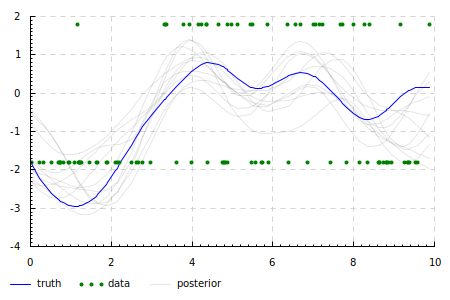

In [17]:
toRenderable $ do
  plot $ line "truth" [list x `zip` list y]
  plot $ points "data" $ list x `zip` [if b then 1.8 else -1.8 | b <- list z]
  setColors [black `withOpacity` 0.1]
  plot $ line "posterior" [list x `zip` list y' | (i,y') <- [0..] `zip` samples, i `mod` 100 == 0]